In [1]:
# -*- coding: utf8


from scipy.special import gammaln
from scipy.special import psi


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import sys

In [2]:
def init_matplotlib():
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('tableau-colorblind10')
    
    
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [3]:
init_matplotlib()
plt.ion()

In [4]:
def load_centralities(fpath):
    df = pd.read_csv(fpath, index_col=0)
    new_index = []
    if 'allmusic' in fpath:
        am_names = pd.read_csv('../centrality-csvs/allmusic_names.csv',
                               names=['id', 'name'],
                               header=None,
                               index_col=0)
        
        for id_ in df.index:
            new_index.append(am_names.loc[id_][0])
        df.index = pd.Index(new_index)
        df = df.sort_index()
    
    node2id = {}
    id2node = {}
    active_decades = {}
    for artist_id, row in df.iterrows():
        key = artist_id
        while key in node2id:
            key = '{}-repeated'.format(key)
        node2id[key] = len(node2id)
        id2node[node2id[key]] = key
        active_decades[key] = set(map(int, row.dropna().index))
    
    delta = int(df.columns[1]) - int(df.columns[0])
    return df.sort_index(), node2id, id2node, delta, active_decades

In [5]:
def get_rank_positions(decade, node2id, df_centrality, inferior=False):
    n = len(node2id)
    aux = np.zeros(n)
    for node, value in df_centrality[str(decade)].iteritems():
        if type(node) != str and np.isnan(node):
            continue
        if np.isnan(value):
            aux[node2id[node]] = np.nan
        else:
            aux[node2id[node]] = value
    
    # mask nodes which do not exist
    aux = np.ma.array(aux, mask=np.isnan(aux),
                      fill_value=np.nan)
    valid = (~(aux.mask))
    valid_n = valid.sum()

    # rank filtering out nodes which do not exist
    ranks = ss.mstats.rankdata(aux)

    values = np.zeros(shape=(2, n), dtype='d')
    if inferior:
        values[1] = valid_n - ranks # number above
        values[0] = ranks           # number below
    else:
        values[0] = valid_n - ranks # number above
        values[1] = ranks           # number below
        
    # mask nodes which do not exit
    new_mask = np.array([ranks == 0, ranks==0])
    values = np.ma.array(values, mask=new_mask,
                         fill_value=np.nan)
    
    return values.T + 1   # +1 to avoid zeroes

In [6]:
def rank_surprise_detector(observed, prior):
    '''
    Computes the rank based surprise.
    
    Arguments
    ---------
    observed: masked array: with the number of nodes with centrality
              values greater then (observed[i][0]) or lower
              then (observed[i][1]) node i.
    prior:    masked array: the prior for each node. prior[i][0] is
              alpha, and prior[i][1] is beta. In our paper, we set the prior
              for each such that prior[i][0] / sum(prior[i])
              captures the fraction of other nodes with centrality
              greater than node i.
    
    Masked arrays are required to dead with missing data. When something
    is present in the observed but not the prior, we force a flat prior.
    
    Both arguments are o shape (n_nodes, 2). Organizing data like
    this make's it easy to compute the posterior = observed + prior.
    
    Returns
    -------
    The posterior and the surprise for each node
    
    References
    ----------
    
    [1]  Penny  WD  (2001):  “KL-Divergences  of  Normal,
         Gamma,  Dirichlet  and  Wishartdensities”.
         University College, London;
         URL: www.fil.ion.ucl.ac.uk/∼wpenny/publications/densities.ps.
    [2]  Kullback-Leibler Divergence Between Two Dirichlet
         (and Beta) Distributions. URL: http://bariskurt.com/
    '''
    
    # Flat prior on new nodes, just arrived in the network
    # new_nodes = (observed.mask == False) & (prior.mask == True)
    # prior = prior.copy()
    # prior[new_nodes] = 1
    # assert (observed.mask == prior.mask).all()
    
    posterior = prior + observed
    
    # from here the code is a dkl divergence of dirichlets. adapted and double
    # checked [1] and [2]
    
    d_obs = gammaln(posterior.sum(axis=1)) - gammaln(posterior).sum(axis=1)
    d_pri = gammaln(prior.sum(axis=1)) - gammaln(prior).sum(axis=1)
    individual_factors = (posterior - prior).T * \
            (psi(posterior).T - psi(posterior.sum(axis=1)))
    surprises_masked = d_obs - d_pri + individual_factors.sum(axis=0)
    
    # force zero surprise on data which does not exist
    surprises = np.zeros(len(surprises_masked), dtype='d')
    surprises[~surprises_masked.mask] = surprises_masked[~surprises_masked.mask]
    
    return prior, posterior, surprises

In [7]:
def hypothesis_past(year, delta, node2id, df):
    prior = get_rank_positions(year - delta, node2id, df)
    return prior

def hypothesis_growth(year, delta, node2id, df):
    position_2d_ago = get_rank_positions(year - 2 * delta, node2id, df)
    position_1d_ago = get_rank_positions(year - delta, node2id, df)
    prior = position_1d_ago * (position_1d_ago / position_2d_ago)
    return prior

def hypothesis_flat(year, delta, node2id, df):
    prior = get_rank_positions(year, node2id, df) # just to get the shape
    prior[:] = 1
    return prior

In [8]:
def top_twenty_example():
    df, node2id, id2node, delta, active_decades = \
            load_centralities('../centrality-csvs/allmusic_pageranks.csv')
    for year in map(int, df.columns[1:]):
        obs = get_rank_positions(year, node2id, df)

        hyp = hypothesis_past
        prior_unrmd = hyp(year, delta, node2id, df)
        prior, posterior, surprises = rank_surprise_detector(obs, prior_unrmd)
        
        print(year, ' mean surprise ->', surprises.mean())
        top = surprises.argsort()[-20:][::-1]
        for ni in top:
            p = obs[ni][0] / obs[ni].sum()
            beta = ss.beta(a=posterior[ni][0], b=posterior[ni][1])
            print(year-delta, year, id2node[ni],
                  surprises[ni],
                  beta.pdf(p),
                  sep='\t')
        print()

In [9]:
top_twenty_example()

1950  mean surprise -> 1.0066529840830776
1940	1950	Fats Domino	438.4899773293786	0.0
1940	1950	Bill Haley	410.5437985525555	3.851190643505887e-301
1940	1950	Clarence "Gatemouth" Brown	398.3732331723072	8.83906660189055e-280
1940	1950	The Clovers	390.8320825701562	1.5857975061398093e-267
1940	1950	Clarence Fountain	355.8998728126228	1.3669859383705187e-218
1940	1950	Bo Diddley	354.15891534261027	1.956172641879555e-216
1940	1950	Roy Hamilton	322.2432665134147	1.201798634406513e-180
1940	1950	Kenny Dorham	308.39012677841674	5.2980957333706035e-167
1940	1950	Eddie Fisher	286.89407719979704	1.1273945065959337e-147
1940	1950	Billy Taylor	275.56659932279877	2.792645505867046e-138
1940	1950	Buck Owens	266.43813296307417	4.588164296963212e-131
1940	1950	Esther Phillips	263.59768852976686	7.016168835186608e-129
1940	1950	Ernie Royal	262.1849843034688	8.359257263896678e-128
1940	1950	Jimmy Reed	250.10409173488688	2.2943259575739837e-192
1940	1950	Willie Johnson	241.13809375436858	1.5347499868001

In [17]:
def heat_map_surprise_vs_pos():
    df, node2id, id2node, delta, active_decades = \
            load_centralities('../centrality-csvs/allmusic_pageranks.csv')

    decade = int(df.columns[-1])

    prior_unrmd = hypothesis_past(decade, 4 * delta, node2id, df)
    obs = get_rank_positions(decade, node2id, df)
    surprises = rank_surprise_detector(obs, prior_unrmd)[-1]

    prev = 1 - prior_unrmd[:, 0] / prior_unrmd.sum(axis=1)
    new = 1 - obs[:, 0] / obs.sum(axis=1)

    y = new
    x = prev
    z = surprises

    fig, axes = plt.subplots(2, 1, figsize=(8, 9))
    
    axes[0].tricontour(x, y, surprises, levels=20, linewidths=0.5, colors='k')
    im = axes[0].tricontourf(x, y, surprises, levels=20, cmap='magma_r')

    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('Surprise')

    l = np.linspace(0, 1, 10)
    axes[0].plot(l, l, '--', color='magenta', lw=1)
    axes[0].set_xlabel(r'$1-\hat{\theta}_{i, t-1}$: Frac. inferior on timestamp t-1')
    axes[0].set_ylabel(r'$1-\hat{\theta}_{i, t}$: Frac. inferior on timestamp t')
    despine(axes[0])

    axes[1].tricontour(x, y, np.abs(x-y), levels=20, linewidths=0.5, colors='k')
    im = axes[1].tricontourf(x, y, np.abs(x-y), levels=20, cmap='magma_r')    
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label('Mod Diff.')

    l = np.linspace(0, 1, 10)
    axes[1].plot(l, l, '--', color='magenta', lw=1)
    axes[1].set_xlabel(r'$1-\hat{\theta}_{i, t-1}$: Frac. inferior on timestamp t-1')
    axes[1].set_ylabel(r'$1-\hat{\theta}_{i, t}$: Frac. inferior on timestamp t')
    despine(axes[1])

ValueError: z must not contain masked points within the triangulation

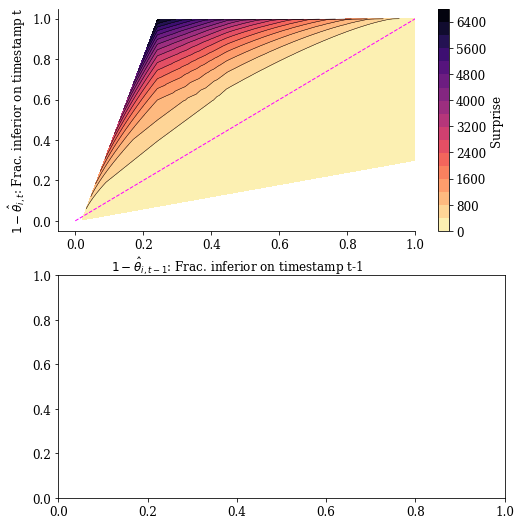

In [18]:
heat_map_surprise_vs_pos()

## Generate CSVs for Paper from Here

From here it's just one big script to generate the csvs used for results in the paper.

In [12]:
def create_am_csvs():
    df_pagerank, node2id_pagerank, id2node_pagerank, delta, active_decades = \
            load_centralities('../centrality-csvs/allmusic_pageranks.csv')
    df_disrupt, node2id_disrupt, id2node_disrupt, delta, active_decades = \
            load_centralities('../centrality-csvs/allmusic_disruption.csv')

    assert len(df_pagerank) == len(df_disrupt)
    assert len(df_pagerank) == len(node2id_pagerank)
    assert len(df_pagerank) == len(id2node_pagerank)
    
    for i in range(len(df_pagerank)):
        assert df_pagerank.index[i] == df_disrupt.index[i]
    
    rv = {
        'name' : [],
        'year': [],
        'active': [],

        'pagerank_obs_curr_t_nabove': [],
        'pagerank_obs_curr_t_nbelow': [],

        'pagerank_prior_hyp_past_t_alpha': [],
        'pagerank_prior_hyp_past_t_beta': [],
        'pagerank_posterior_hyp_past_t_alpha': [],
        'pagerank_posterior_hyp_past_t_beta': [],
        'pagerank_surprise_hyp_past_t': [],

        'pagerank_prior_hyp_growth_t_alpha': [],
        'pagerank_prior_hyp_growth_t_beta': [],
        'pagerank_posterior_hyp_growth_t_alpha': [],
        'pagerank_posterior_hyp_growth_t_beta': [],
        'pagerank_surprise_hyp_growth_t': [],

        'disrupt_obs_curr_t_nabove': [],
        'disrupt_obs_curr_t_nbelow': [],

        'disrupt_prior_hyp_past_t_alpha': [],
        'disrupt_prior_hyp_past_t_beta': [],
        'disrupt_posterior_hyp_past_t_alpha': [],
        'disrupt_posterior_hyp_past_t_beta': [],
        'disrupt_surprise_hyp_past_t': [],

        'disrupt_prior_hyp_growth_t_alpha': [],
        'disrupt_prior_hyp_growth_t_beta': [],
        'disrupt_posterior_hyp_growth_t_alpha': [],
        'disrupt_posterior_hyp_growth_t_beta': [],
        'disrupt_surprise_hyp_growth_t': []
    }

    for year in map(int, df_pagerank.columns[2:]):
        obs_pagerank = get_rank_positions(year, node2id_pagerank, df_pagerank)

        name_col = []
        year_col = []
        active_col = []
        for i in range(len(obs_pagerank)):
            name_col.append(id2node_pagerank[i])
            year_col.append(year)
            valid = year in active_decades[id2node_pagerank[i]]
            active_col.append(valid)

        rv['name'].extend(name_col)
        rv['year'].extend(year_col)
        rv['active'].extend(active_col)

        prior_past, posterior_past, surprises_past = \
                rank_surprise_detector(obs_pagerank,
                                       hypothesis_past(year,
                                                       delta,
                                                       node2id_pagerank,
                                                       df_pagerank))

        prior_growth, posterior_growth, surprises_growth = \
                rank_surprise_detector(obs_pagerank,
                                       hypothesis_growth(year,
                                                         delta,
                                                         node2id_pagerank,
                                                         df_pagerank))

        rv['pagerank_obs_curr_t_nabove'].extend(obs_pagerank[:, 0])
        rv['pagerank_obs_curr_t_nbelow'].extend(obs_pagerank[:, 1])

        rv['pagerank_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
        rv['pagerank_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
        rv['pagerank_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
        rv['pagerank_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
        rv['pagerank_surprise_hyp_past_t'].extend(surprises_past)

        rv['pagerank_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
        rv['pagerank_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
        rv['pagerank_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
        rv['pagerank_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
        rv['pagerank_surprise_hyp_growth_t'].extend(surprises_growth)


        obs_disrupt = get_rank_positions(year, node2id_disrupt, df_disrupt)
        prior_past, posterior_past, surprises_past = \
                rank_surprise_detector(obs_disrupt,
                                       hypothesis_past(year,
                                                       delta,
                                                       node2id_disrupt,
                                                       df_disrupt))

        prior_growth, posterior_growth, surprises_growth = \
                rank_surprise_detector(obs_disrupt,
                                       hypothesis_growth(year,
                                                         delta,
                                                         node2id_disrupt,
                                                         df_disrupt))

        rv['disrupt_obs_curr_t_nabove'].extend(obs_disrupt[:, 0])
        rv['disrupt_obs_curr_t_nbelow'].extend(obs_disrupt[:, 1])

        rv['disrupt_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
        rv['disrupt_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
        rv['disrupt_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
        rv['disrupt_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
        rv['disrupt_surprise_hyp_past_t'].extend(surprises_past)

        rv['disrupt_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
        rv['disrupt_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
        rv['disrupt_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
        rv['disrupt_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
        rv['disrupt_surprise_hyp_growth_t'].extend(surprises_growth)

    rv = pd.DataFrame(rv)
    rv = rv[rv['active']]
    rv.to_csv('allmusic_surprises.csv', index=False)
create_am_csvs()

In [14]:
def create_whosampled_csvs():
    df_pagerank, node2id_pagerank, id2node_pagerank, delta, active_decades = \
            load_centralities('../centrality-csvs/whosampled_pagerank.csv')
    df_disrupt, node2id_disrupt, id2node_disrupt, delta, active_decades = \
            load_centralities('../centrality-csvs/whosampled_disruption.csv')

    assert len(df_pagerank) == len(df_disrupt)
    assert len(df_pagerank) == len(node2id_pagerank)
    assert len(df_pagerank) == len(id2node_pagerank)

    for i in range(len(df_pagerank)):
        assert df_pagerank.index[i] == df_disrupt.index[i]

    for year in map(int, df_pagerank.columns[10:]):
        rv = {
            'name' : [],
            'year': [],
            'active': [],

            'pagerank_obs_curr_t_nabove': [],
            'pagerank_obs_curr_t_nbelow': [],

            'pagerank_prior_hyp_past_t_alpha': [],
            'pagerank_prior_hyp_past_t_beta': [],
            'pagerank_posterior_hyp_past_t_alpha': [],
            'pagerank_posterior_hyp_past_t_beta': [],
            'pagerank_surprise_hyp_past_t': [],

            'pagerank_prior_hyp_growth_t_alpha': [],
            'pagerank_prior_hyp_growth_t_beta': [],
            'pagerank_posterior_hyp_growth_t_alpha': [],
            'pagerank_posterior_hyp_growth_t_beta': [],
            'pagerank_surprise_hyp_growth_t': [],

            'disrupt_obs_curr_t_nabove': [],
            'disrupt_obs_curr_t_nbelow': [],

            'disrupt_prior_hyp_past_t_alpha': [],
            'disrupt_prior_hyp_past_t_beta': [],
            'disrupt_posterior_hyp_past_t_alpha': [],
            'disrupt_posterior_hyp_past_t_beta': [],
            'disrupt_surprise_hyp_past_t': [],

            'disrupt_prior_hyp_growth_t_alpha': [],
            'disrupt_prior_hyp_growth_t_beta': [],
            'disrupt_posterior_hyp_growth_t_alpha': [],
            'disrupt_posterior_hyp_growth_t_beta': [],
            'disrupt_surprise_hyp_growth_t': []
        }

        obs_pagerank = get_rank_positions(year, node2id_pagerank, df_pagerank)

        name_col = []
        year_col = []
        active_col = []
        for i in range(len(obs_pagerank)):
            name_col.append(id2node_pagerank[i])
            year_col.append(year)
            valid = year in active_decades[id2node_pagerank[i]]
            active_col.append(valid)

        rv['name'].extend(name_col)
        rv['year'].extend(year_col)
        rv['active'].extend(active_col)

        prior_past, posterior_past, surprises_past = \
                rank_surprise_detector(obs_pagerank,
                                       hypothesis_past(year,
                                                       delta,
                                                       node2id_pagerank,
                                                       df_pagerank))

        prior_growth, posterior_growth, surprises_growth = \
                rank_surprise_detector(obs_pagerank,
                                       hypothesis_growth(year,
                                                         delta,
                                                         node2id_pagerank,
                                                         df_pagerank))

        rv['pagerank_obs_curr_t_nabove'].extend(obs_pagerank[:, 0])
        rv['pagerank_obs_curr_t_nbelow'].extend(obs_pagerank[:, 1])

        rv['pagerank_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
        rv['pagerank_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
        rv['pagerank_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
        rv['pagerank_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
        rv['pagerank_surprise_hyp_past_t'].extend(surprises_past)

        rv['pagerank_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
        rv['pagerank_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
        rv['pagerank_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
        rv['pagerank_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
        rv['pagerank_surprise_hyp_growth_t'].extend(surprises_growth)


        obs_disrupt = get_rank_positions(year, node2id_disrupt, df_disrupt)
        prior_past, posterior_past, surprises_past = \
                rank_surprise_detector(obs_disrupt,
                                       hypothesis_past(year,
                                                       delta,
                                                       node2id_disrupt,
                                                       df_disrupt))

        prior_growth, posterior_growth, surprises_growth = \
                rank_surprise_detector(obs_disrupt,
                                       hypothesis_growth(year,
                                                         delta,
                                                         node2id_disrupt,
                                                         df_disrupt))

        rv['disrupt_obs_curr_t_nabove'].extend(obs_disrupt[:, 0])
        rv['disrupt_obs_curr_t_nbelow'].extend(obs_disrupt[:, 1])

        rv['disrupt_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
        rv['disrupt_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
        rv['disrupt_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
        rv['disrupt_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
        rv['disrupt_surprise_hyp_past_t'].extend(surprises_past)

        rv['disrupt_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
        rv['disrupt_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
        rv['disrupt_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
        rv['disrupt_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
        rv['disrupt_surprise_hyp_growth_t'].extend(surprises_growth)

        rv = pd.DataFrame(rv)
        rv = rv[rv['active']]
        rv.to_csv('whosampled_surprises-{}.csv'.format(year), index=False)
create_whosampled_csvs()